# Explorative Datenanalyse

In [27]:
%pip install numpy
%pip install pandas
%pip install pyarrow
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note

# Imports

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Import Data

In [30]:
products_source = pd.read_csv('data/products.csv')
stores_source   = pd.read_csv('data/stores.csv')

In [31]:
transaction_lines_test_source   = pd.read_parquet('data/transaction_lines_test_1.parquet')
transaction_lines_train_source  = pd.read_parquet('data/transaction_lines_train_1.parquet')
transactions_test_source        = pd.read_parquet('data/transactions_test_1.parquet')
transactions_train_source       = pd.read_parquet('data/transactions_train_1.parquet')

# Joint Set erstellen

In [32]:
# Merge transactions with stores. Keep all transactions (left join).
# Suffix '_store' is added to columns from products_source if they conflict
transactions_enriched = pd.merge(
    transaction_lines_test_source,
    products_source,
    left_on='product_id',
    right_on='id',  # 'id' column from stores_source
    how='left',
    suffixes=('', '_product')  # Add suffix to store columns if needed
)

# Drop the redundant 'id' column from the stores table after merge
transactions_enriched = transactions_enriched.drop(columns=['id_product'], errors='ignore')  # Use errors='ignore' in case suffix wasn't needed

print("Transactions enriched with product info:")
print(transactions_enriched.info())


Transactions enriched with product info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8647089 entries, 0 to 8647088
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      int64         
 1   transaction_id          object        
 2   product_id              object        
 3   timestamp               datetime64[us]
 4   pieces_or_weight        float64       
 5   sales_price             float64       
 6   was_voided              bool          
 7   camera_product_similar  object        
 8   camera_certainty        float64       
 9   base_product_id         object        
 10  category                object        
 11  price                   float64       
 12  popularity              float64       
 13  valid_from              object        
 14  valid_to                object        
 15  sold_by_weight          object        
 16  weight                  float64       
 17  age_r

In [33]:
# Merge transaction lines with stores. Keep all lines (left join).
# Suffix '_store' is added to columns from stores_source if they conflict
source_enriched = pd.merge(
    transactions_train_source,  # Transaktionsdaten
    stores_source,  # Stores-Daten
    left_on='store_id',  # Verknüpfung basierend auf der 'store_id' in den Transaktionsdaten
    right_on='id',  # Verknüpfung basierend auf der 'id' in den Stores-Daten
    how='left',  # Left Join, um alle Zeilen aus den Transaktionsdaten zu behalten
    suffixes=('', '_store')  # Falls Namenskonflikte existieren, wird '_store' angehängt
)

# Drop the redundant 'id' column from the stores table after merge
source_enriched = source_enriched.drop(columns=['id_store'], errors='ignore')  # Entfernt die redundante 'id_store' Spalte

# Print the resulting DataFrame information
print("Transaction enriched with store info:")
print(source_enriched.info())


Transaction enriched with store info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558245 entries, 0 to 1558244
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1558245 non-null  object        
 1   store_id           1558245 non-null  object        
 2   cash_desk          1558245 non-null  int64         
 3   transaction_start  1558245 non-null  datetime64[us]
 4   transaction_end    1558245 non-null  datetime64[us]
 5   total_amount       1558245 non-null  float64       
 6   n_lines            1558245 non-null  int64         
 7   payment_medium     1558245 non-null  object        
 8   customer_feedback  108330 non-null   float64       
 9   damage             155692 non-null   float64       
 10  label              1558245 non-null  object        
 11  opening_date       1558245 non-null  object        
 12  location           1558245 non-null  object   

# Tasactions enriched bereinigung

So, wir wollen uns ein training dataframe bauen. Dafür müssen wir nach und nach alle columns durchgehen und anschauen was die beste wahl hier wäre. Wir analysieren den ganzen datensatz um allen daten gerächt zu werden, aber natürlich wollen wir unser trainings set nur auf den gelabelten Daten durchführen.

In [34]:
transactions_cleaned = transactions_enriched.copy()

In [37]:
# Beispiel: DataFrame laden (ersetzt das durch deinen eigenen Ladevorgang)
# transactions_cleaned = pd.read_csv('deine_datei.csv')

# Vorschau anzeigen
print("Spaltenübersicht im DataFrame:")
print(transactions_cleaned.columns)

# Überprüfen, ob die Spalte 'label' existiert
if 'label' in transactions_cleaned.columns:
    # Zeilen entfernen, bei denen 'label' den Wert 'UNKNOWN' hat
    transactions_cleaned = transactions_cleaned[transactions_cleaned['label'] != 'UNKNOWN']
    print("Zeilen mit 'UNKNOWN' in der Spalte 'label' wurden entfernt.")
else:
    print("Die Spalte 'label' wurde nicht im DataFrame gefunden.")

# Optional: Vorschau auf bereinigte Daten
print("\nVorschau auf den bereinigten DataFrame:")
print(transactions_cleaned.head())


Spaltenübersicht im DataFrame:
Index(['id', 'transaction_id', 'product_id', 'timestamp', 'pieces_or_weight',
       'sales_price', 'was_voided', 'camera_product_similar',
       'camera_certainty', 'base_product_id', 'category', 'price',
       'popularity', 'valid_from', 'valid_to', 'sold_by_weight', 'weight',
       'age_restricted'],
      dtype='object')
Die Spalte 'label' wurde nicht im DataFrame gefunden.

Vorschau auf den bereinigten DataFrame:
   id                        transaction_id  \
0  19  103a0875-8a44-42e7-8c69-3c927ba6d1b0   
1  20  103a0875-8a44-42e7-8c69-3c927ba6d1b0   
2  21  103a0875-8a44-42e7-8c69-3c927ba6d1b0   
3  22  103a0875-8a44-42e7-8c69-3c927ba6d1b0   
4  23  103a0875-8a44-42e7-8c69-3c927ba6d1b0   

                             product_id                  timestamp  \
0  ed7f76d7-3aab-456d-ae5d-a7d6c9bfd8f7 2024-03-16 08:13:00.698354   
1  88f0ce90-e55f-49d1-80b2-04e9c9454830 2024-03-16 08:13:05.449080   
2  9b9ef00d-a041-4ef1-bd6e-70b83cc424d6 2024-03-16 

# Kopiere das Original zur Sicherheit


In [40]:
products_cleaned = products_source.copy()

# 1. NULLWERTE PRÜFEN UND BEHANDELN


In [41]:
print("🔍 Nullwerte vor Bereinigung:")
print(products_cleaned.isnull().sum())

# Mediangewicht berechnen (nur für Produkte mit Gewicht)
median_weight = products_cleaned.loc[products_cleaned['sold_by_weight'] == True, 'weight'].median()

# Fehlende Gewichte auffüllen
products_cleaned['weight'] = products_cleaned.apply(
    lambda row: median_weight if pd.isna(row['weight']) and row['sold_by_weight'] else (
        0 if pd.isna(row['weight']) else row['weight']
    ),
    axis=1
)

print("\n✅ Nullwerte nach Bereinigung:")
print(products_cleaned.isnull().sum())

🔍 Nullwerte vor Bereinigung:
id                    0
base_product_id       0
category              0
price                 0
popularity            0
valid_from            0
valid_to           1790
sold_by_weight        0
weight             2505
age_restricted        0
dtype: int64

✅ Nullwerte nach Bereinigung:
id                    0
base_product_id       0
category              0
price                 0
popularity            0
valid_from            0
valid_to           1790
sold_by_weight        0
weight             2155
age_restricted        0
dtype: int64


/Users/saji/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


# 2. UNNÖTIGE SPALTEN LÖSCHEN


In [42]:
# 'base_product_id' ist redundant mit 'id'
products_cleaned.drop(columns=['base_product_id'], inplace=True)

# 3. DATENTYPEN KONVERTIEREN


In [43]:
# Datumsangaben in echtes Datumsformat konvertieren
products_cleaned['valid_from'] = pd.to_datetime(products_cleaned['valid_from'], errors='coerce')
products_cleaned['valid_to'] = pd.to_datetime(products_cleaned['valid_to'], errors='coerce')

# Numerische Werte in float konvertieren
for col in ['price', 'popularity', 'weight']:
    products_cleaned[col] = pd.to_numeric(products_cleaned[col], errors='coerce')


# 4. DUPLIKATE PRÜFEN UND ENTFERNEN


In [45]:
duplicates = products_cleaned.duplicated().sum()
print(f"\n🔁 Duplikate gefunden: {duplicates}")
products_cleaned.drop_duplicates(inplace=True)


🔁 Duplikate gefunden: 0


# 5. AUSREIßER ERKENNEN UND MELDEN


In [46]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] < lower) | (data[column] > upper)]

for col in ['price', 'weight']:
    outliers = detect_outliers_iqr(products_cleaned, col)
    print(f"\n📈 {col}: {len(outliers)} Ausreißer erkannt.")
    # Optional: Ausreißer entfernen
    # products_cleaned = products_cleaned.drop(outliers.index)


📈 price: 331 Ausreißer erkannt.

📈 weight: 287 Ausreißer erkannt.


# 6. DATEN GRUPPIEREN


In [47]:
# Gruppierung nach Kategorie
category_stats = products_cleaned.groupby('category').agg({
    'price': ['mean', 'min', 'max'],
    'popularity': ['mean', 'min', 'max'],
    'weight': ['mean', 'min', 'max']
}).reset_index()

print("\n📊 Gruppierte Statistik nach Kategorie:")
print(category_stats)



📊 Gruppierte Statistik nach Kategorie:
                    category      price                       popularity  \
                                   mean       min         max       mean   
0                    ALCOHOL   8.516209  1.535425   23.897569   0.066195   
1                     BAKERY   1.377481  0.390000    2.990000   0.153159   
2                  BEVERAGES   0.906645  0.190000    2.190000   0.167470   
3                CONVENIENCE   3.781612  0.790000   12.190000   0.101535   
4                      DAIRY   2.920929  0.490000   10.000000   0.115835   
5               FROZEN_GOODS   4.308613  0.490000   13.790000   0.092424   
6          FRUITS_VEGETABLES  11.949930  1.790000   46.990000   0.028609   
7   FRUITS_VEGETABLES_PIECES   1.311871  0.190000    4.990000   0.155148   
8                  HOUSEHOLD   4.149497  0.790000   13.790000   0.095622   
9        LIMITED_TIME_OFFERS  71.891314  5.290000  589.490000   0.006275   
10           LONG_SHELF_LIFE   1.683794  0.29000

# 7. FINALISIERUNG


In [48]:
products_cleaned.reset_index(drop=True, inplace=True)

# Optional: Speichern
# products_cleaned.to_csv("products_cleaned.csv", index=False)

# Vorschau
print("\n📦 Bereinigte Datenvorschau:")
print(products_cleaned.head())


📦 Bereinigte Datenvorschau:
                                     id                  category  price  \
0  fffcbc8a-f73f-496c-8f4e-671a7f0b7ab2               CONVENIENCE   2.49   
1  608a870f-f898-486c-b66d-8979855c1cbb         FRUITS_VEGETABLES  12.79   
2  3758a745-6170-4650-ad9d-0f8b6c6b781d           LONG_SHELF_LIFE   1.79   
3  d5579e9a-8fd4-4ca5-a902-88348d8e0130  FRUITS_VEGETABLES_PIECES   1.49   
4  ad191c01-3a19-4ae9-b7a0-1f8fdf227414              FROZEN_GOODS   2.49   

   popularity valid_from   valid_to  sold_by_weight    weight  age_restricted  
0    0.121549 2024-10-29 2025-01-06           False  0.500000           False  
1    0.015492 2013-12-27 2014-07-16            True       NaN           False  
2    0.139815 2023-02-11 2023-05-09           False  0.500000           False  
3    0.148460 2023-09-03 2023-09-24           False  1.397181           False  
4    0.121549 2011-05-05 2013-08-27           False  1.630000           False  


# 8. Bereinigung: transaction_lines


In [49]:
# Nullwerte entfernen, falls kritisch
transaction_lines_test_source = transaction_lines_test_source.dropna(subset=['transaction_id', 'product_id'])

# Korrekte Typen sicherstellen
transaction_lines_test_source['transaction_id'] = transaction_lines_test_source['transaction_id'].astype(str)
transaction_lines_test_source['product_id'] = transaction_lines_test_source['product_id'].astype(str)

# Optional: Nullwerte bei Mengen durch 0 ersetzen
if 'quantity' in transaction_lines_test_source.columns:
    transaction_lines_test_source['quantity'] = pd.to_numeric(transaction_lines_test_source['quantity'], errors='coerce').fillna(0)

# Duplikate entfernen
transaction_lines_test_source = transaction_lines_test_source.drop_duplicates()


# 9. Bereinigung: products.csv


In [50]:
# Typkonvertierung
products_source['id'] = products_source['id'].astype(str)

# Nullwerte behandeln (z. B. Gewicht auffüllen)
if 'weight' in products_source.columns and 'sold_by_weight' in products_source.columns:
    median_weight = products_source.loc[products_source['sold_by_weight'] == True, 'weight'].median()
    products_source['weight'] = products_source.apply(
        lambda row: median_weight if pd.isna(row['weight']) and row['sold_by_weight'] else (
            0 if pd.isna(row['weight']) else row['weight']
        ),
        axis=1
    )

/Users/saji/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


# 10. Merge: Transaktionszeilen + Produkte


In [51]:
merged = pd.merge(
    transaction_lines_test_source,
    products_source,
    left_on='product_id',
    right_on='id',
    how='left',
    suffixes=('', '_product')
)

# Redundante Spalte entfernen
merged.drop(columns=['id'], inplace=True)


# 11. Ergebnis anzeigen


In [52]:
print("\n✅ Ergebnisvorschau nach Merge:")
print(merged.head())
print("\n📊 Shape:", merged.shape)



✅ Ergebnisvorschau nach Merge:
                         transaction_id                            product_id  \
0  103a0875-8a44-42e7-8c69-3c927ba6d1b0  ed7f76d7-3aab-456d-ae5d-a7d6c9bfd8f7   
1  103a0875-8a44-42e7-8c69-3c927ba6d1b0  88f0ce90-e55f-49d1-80b2-04e9c9454830   
2  103a0875-8a44-42e7-8c69-3c927ba6d1b0  9b9ef00d-a041-4ef1-bd6e-70b83cc424d6   
3  103a0875-8a44-42e7-8c69-3c927ba6d1b0  6bb7e529-1c3d-4527-bfc4-096178f0df6c   
4  103a0875-8a44-42e7-8c69-3c927ba6d1b0  4606ae2f-4d26-4155-908d-f58de39ee2b8   

                   timestamp  pieces_or_weight  sales_price  was_voided  \
0 2024-03-16 08:13:00.698354              12.0        11.88       False   
1 2024-03-16 08:13:05.449080               4.0         1.96       False   
2 2024-03-16 08:13:06.969691              10.0         9.90       False   
3 2024-03-16 08:13:11.235237               2.0         0.58       False   
4 2024-03-16 08:13:12.301929              15.0         7.35       False   

  camera_product_similar  came

# 12. Nullwerte visualisieren


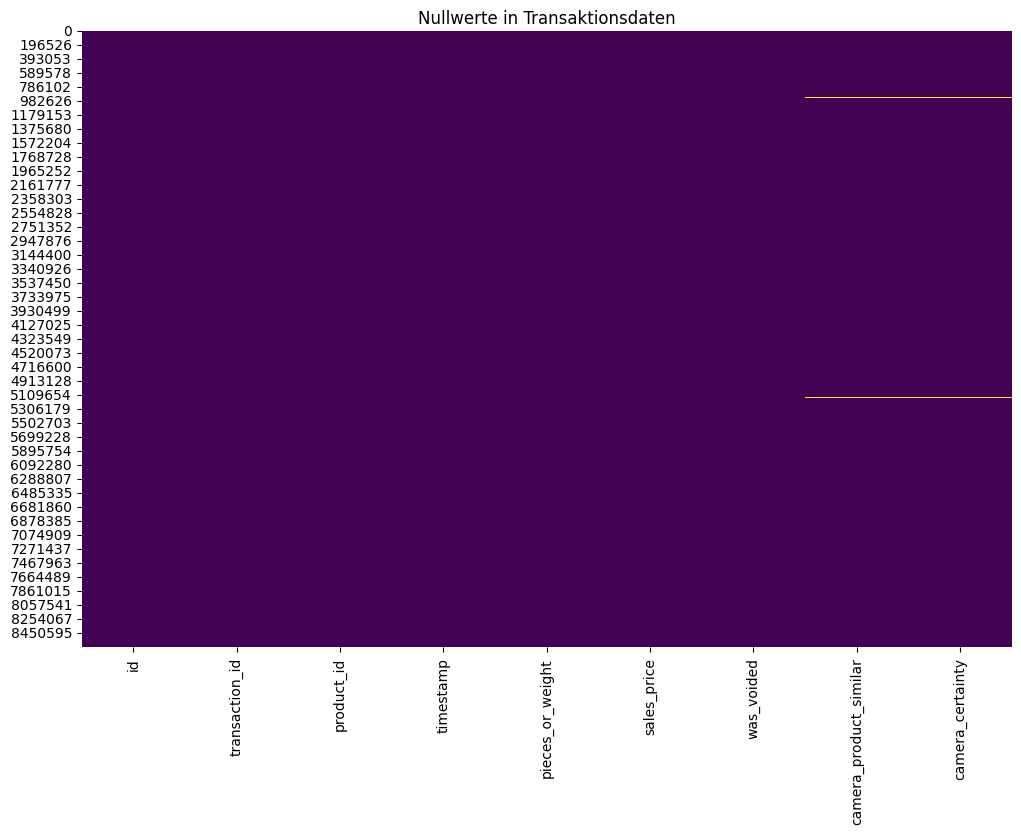

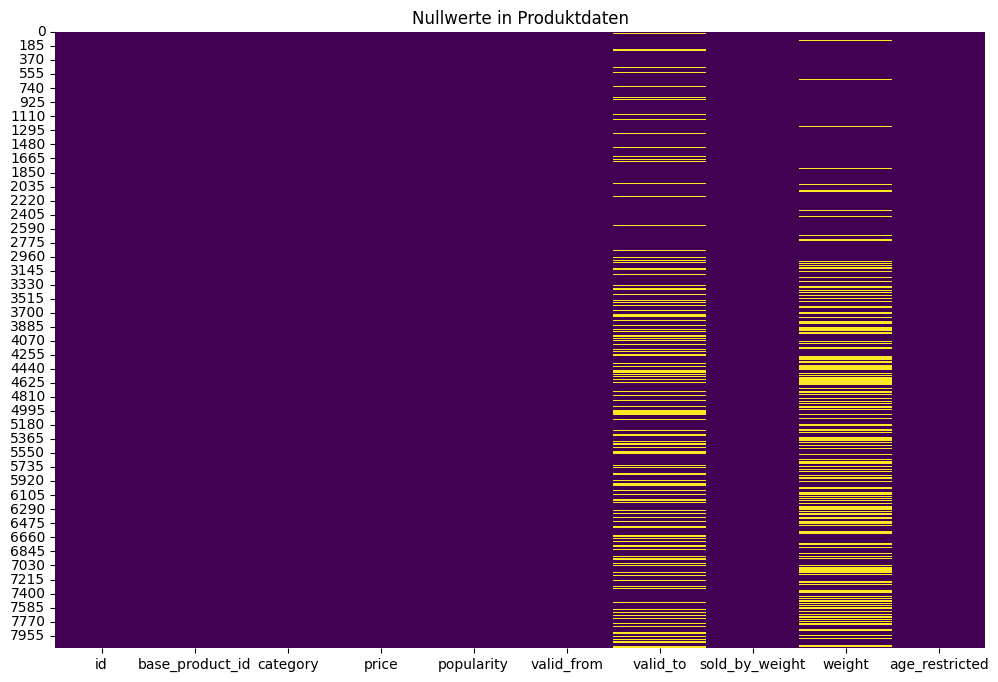

In [53]:
# Visualisierung der Nullwerte mit einer Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(transaction_lines_test_source.isnull(), cbar=False, cmap='viridis')
plt.title('Nullwerte in Transaktionsdaten')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(products_source.isnull(), cbar=False, cmap='viridis')
plt.title('Nullwerte in Produktdaten')
plt.show()

# 13. Spalten löschen


In [54]:
# Zeige, wie viele Spalten vor und nach dem Entfernen der Nullwerte bleiben
print(f"Anzahl der Spalten vor Nullwertentfernung (Transaction Lines): {transaction_lines_test_source.shape[1]}")
print(f"Anzahl der Spalten nach Nullwertentfernung (Transaction Lines): {transaction_lines_test_source.dropna(subset=['transaction_id', 'product_id']).shape[1]}")


Anzahl der Spalten vor Nullwertentfernung (Transaction Lines): 9
Anzahl der Spalten nach Nullwertentfernung (Transaction Lines): 9


# 4. Datentypen visualisieren


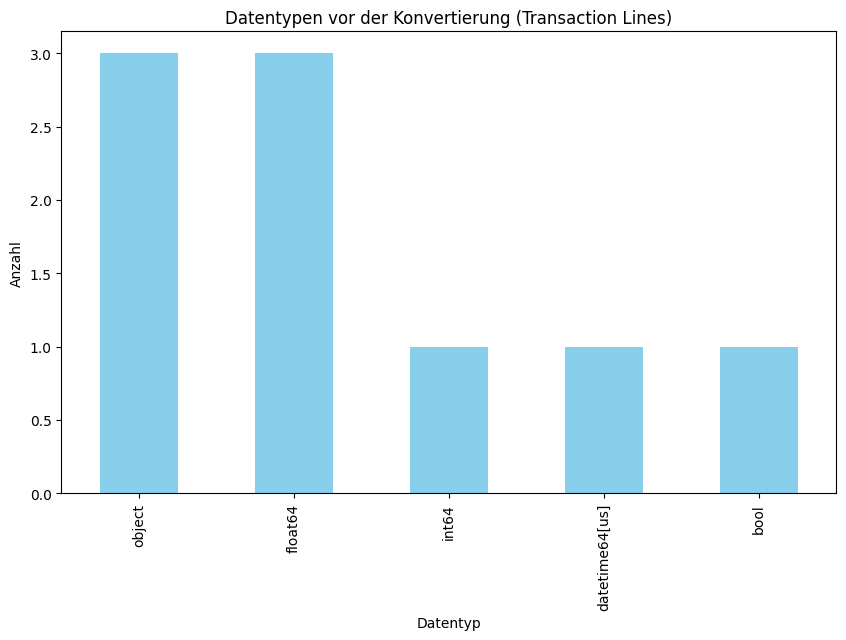

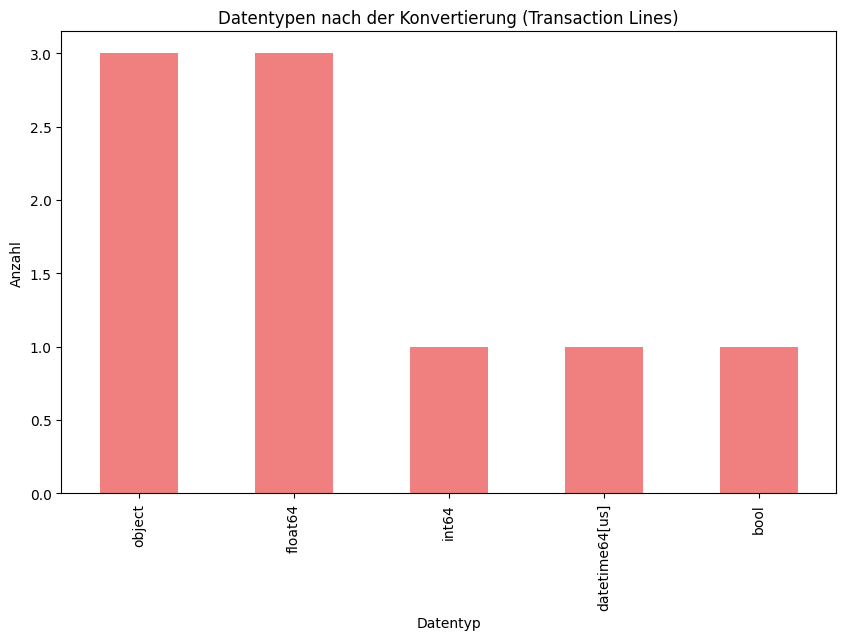

In [55]:
# Vor der Typkonvertierung
plt.figure(figsize=(10, 6))
transaction_lines_test_source.dtypes.value_counts().plot(kind='bar', color='skyblue')
plt.title('Datentypen vor der Konvertierung (Transaction Lines)')
plt.xlabel('Datentyp')
plt.ylabel('Anzahl')
plt.show()

# Nach der Typkonvertierung
transaction_lines_test_source['transaction_id'] = transaction_lines_test_source['transaction_id'].astype(str)
transaction_lines_test_source['product_id'] = transaction_lines_test_source['product_id'].astype(str)

plt.figure(figsize=(10, 6))
transaction_lines_test_source.dtypes.value_counts().plot(kind='bar', color='lightcoral')
plt.title('Datentypen nach der Konvertierung (Transaction Lines)')
plt.xlabel('Datentyp')
plt.ylabel('Anzahl')
plt.show()


# 5. Daten gruppieren (Gruppierung nach einer Spalte und Visualisierung der Verteilung)


In [60]:
# Zunächst sicherstellen, dass die Spalte 'quantity' existiert
if 'quantity' in transaction_lines_test_source.columns:
    # Versuchen, 'quantity' in numerische Werte zu konvertieren, falls sie es nicht sind
    transaction_lines_test_source['quantity'] = pd.to_numeric(transaction_lines_test_source['quantity'], errors='coerce')

    # Gruppierung nach 'product_id' und Summierung der 'quantity'
    grouped_data = transaction_lines_test_source.groupby('product_id')['quantity'].sum().reset_index()

    # Visualisierung der Top 10 Produkte nach Gesamtmenge
    plt.figure(figsize=(12, 6))
    sns.barplot(x='product_id', y='quantity', data=grouped_data.sort_values('quantity', ascending=False).head(10))
    plt.title('Top 10 Produkte nach Gesamtmenge')
    plt.xlabel('Produkt ID')
    plt.ylabel('Gesamtmenge')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("Die Spalte 'quantity' ist nicht vorhanden.")

Die Spalte 'quantity' ist nicht vorhanden.


# 6. Ausreißer prüfen (Boxplot)


In [63]:
# Sicherstellen, dass 'quantity' numerisch ist
if 'quantity' in transaction_lines_test_source.columns:
    # Nullwerte oder ungültige Werte entfernen
    transaction_lines_test_source['quantity'] = pd.to_numeric(transaction_lines_test_source['quantity'], errors='coerce')
    
    # Boxplot zur Darstellung von Ausreißern
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=transaction_lines_test_source['quantity'])
    plt.title('Boxplot der Menge (Quantity)')
    plt.xlabel('Menge')
    plt.show()
else:
    print("Die Spalte 'quantity' ist nicht vorhanden.")

Die Spalte 'quantity' ist nicht vorhanden.


# 7. Duplikate prüfen


Anzahl der Duplikate vor der Bereinigung: 0
Anzahl der Duplikate nach der Bereinigung: 0


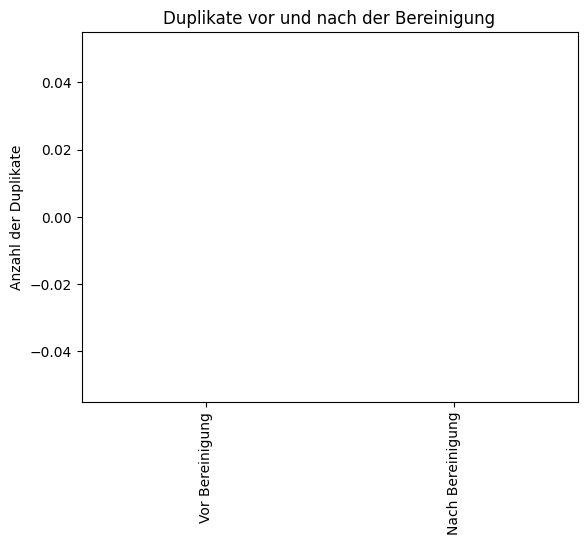

In [64]:
# Vor der Duplikatentfernung
duplicates_before = transaction_lines_test_source.duplicated().sum()
print(f"Anzahl der Duplikate vor der Bereinigung: {duplicates_before}")

# Duplikate entfernen
transaction_lines_test_source = transaction_lines_test_source.drop_duplicates()

# Nach der Duplikatentfernung
duplicates_after = transaction_lines_test_source.duplicated().sum()
print(f"Anzahl der Duplikate nach der Bereinigung: {duplicates_after}")

# Duplikate visualisieren (z. B. als Barplot)
dups = pd.Series([duplicates_before, duplicates_after], index=['Vor Bereinigung', 'Nach Bereinigung'])
dups.plot(kind='bar', color=['red', 'green'])
plt.title('Duplikate vor und nach der Bereinigung')
plt.ylabel('Anzahl der Duplikate')
plt.show()

# Bereinigungsschritte

# 1. Fehlende Werte visualisieren (vor der Bereinigung)

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_78884/581458308.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette="viridis")


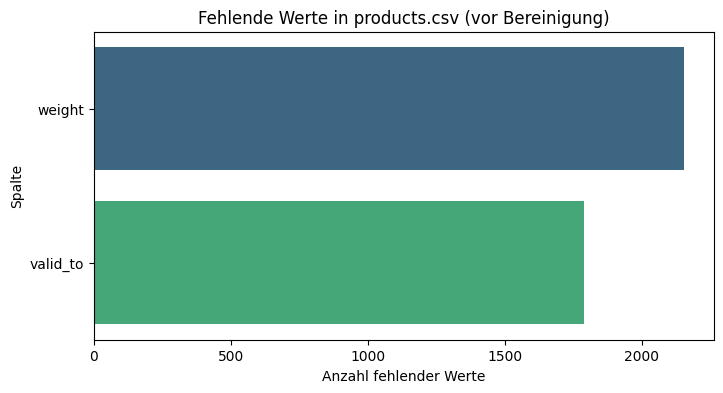

In [66]:
# Fehlende Werte zählen
missing = products_source.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Balkendiagramm
plt.figure(figsize=(8, 4))
sns.barplot(x=missing.values, y=missing.index, palette="viridis")
plt.title("Fehlende Werte in products.csv (vor Bereinigung)")
plt.xlabel("Anzahl fehlender Werte")
plt.ylabel("Spalte")
plt.show()


# 2. Spalte weight bereinigen

In [67]:
# Median-Gewicht für Produkte, die nach Gewicht verkauft werden
if 'weight' in products_source.columns and 'sold_by_weight' in products_source.columns:
    median_weight = products_source.loc[products_source['sold_by_weight'] == True, 'weight'].median()

    products_source['weight'] = products_source.apply(
        lambda row: median_weight if pd.isna(row['weight']) and row['sold_by_weight'] else (
            0 if pd.isna(row['weight']) else row['weight']
        ),
        axis=1
    )

/Users/saji/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


# 3. Spalte valid_to bereinigen

In [69]:
# In datetime konvertieren
products_source['valid_to'] = pd.to_datetime(products_source['valid_to'], errors='coerce')

# Fehlende Werte auffüllen mit einem Platzhalterdatum
standard_date = pd.Timestamp("2099-12-31")
products_source['valid_to'] = products_source['valid_to'].fillna(standard_date)


In [70]:
print("\nNoch fehlende Werte nach Bereinigung:")
print(products_source.isnull().sum())



Noch fehlende Werte nach Bereinigung:
id                    0
base_product_id       0
category              0
price                 0
popularity            0
valid_from            0
valid_to              0
sold_by_weight        0
weight             2155
age_restricted        0
dtype: int64


In [75]:
# Sicherstellen, dass sold_by_weight als bool erkannt wird
products_source['sold_by_weight'] = products_source['sold_by_weight'].astype(str).str.lower().isin(['true', '1', 'ja'])

# weight als float (Zahl) interpretieren
products_source['weight'] = pd.to_numeric(products_source['weight'], errors='coerce')

# Berechne Median für sold_by_weight = True, falls vorhanden
median_weight = products_source.loc[
    (products_source['sold_by_weight']) & (products_source['weight'].notnull()), 'weight'
].median()

# Wenn der Median NaN ist (z.B. alle Werte fehlen), ersetze durch 0
if pd.isna(median_weight):
    median_weight = 0

# Jetzt die fehlenden Werte ersetzen
products_source['weight'] = products_source.apply(
    lambda row: median_weight if pd.isna(row['weight']) else row['weight'],
    axis=1
)

# Prüfung
print("❗ Noch fehlende Werte in 'weight':", products_source['weight'].isnull().sum())


❗ Noch fehlende Werte in 'weight': 0
